In [59]:
import numpy as np
import scipy.ndimage as sn
import scipy.signal as ss
import matplotlib.pyplot as plt
from skimage.io import imsave
import math
from skimage.color import rgb2hsv, hsv2rgb
from skimage.util import random_noise as rn
from PIL.Image import open as imread
from PIL import ImageOps as Iops
import time
import scipy
from matplotlib import cm

In [60]:
def showG(im, cmap = 'gray'):
    if np.average(im) < 1:
        im = im*255
    plt.imshow(im, cmap=cmap, vmin=0, vmax=255)
    return plt.show()

def showC(im, cmap = None):
    plt.imshow(im, cmap=cmap, vmin=0, vmax=255)
    return plt.show()

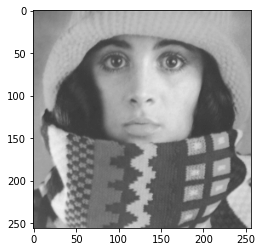

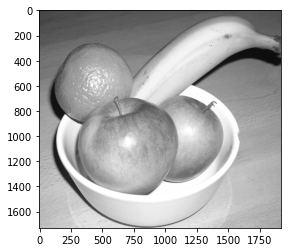

In [61]:
im = imread('trui.png')
g = Iops.grayscale(im)
A = np.array(g)
showG(A)

im2 = imread('bowl_fruit.png')
g2 = Iops.grayscale(im2)
A2 = np.array(g2)
showG(A2)

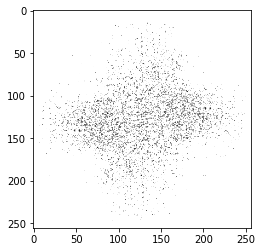

In [62]:
C = np.copy(A)
fft = scipy.fft.fft2(C)
F = np.absolute(fft)
showG(F)

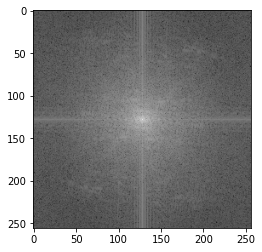

In [63]:
logF = 15*np.log(1 + F)
shiftedF = scipy.fft.fftshift(logF)
showG(shiftedF)

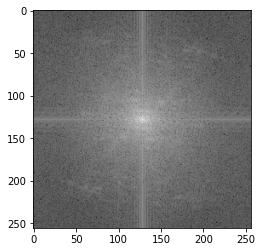

In [156]:
C = np.copy(A) # Copy image 
fft = scipy.fft.fft2(C)
F = np.absolute(fft)
powerF = 8*np.log(1+F*F)
shiftedPowF = scipy.fft.fftshift(powerF)
showG(shiftedPowF)

In [65]:
#Part b
def conv(img1, k):
    n,m = img1.shape
    out = np.zeros((n,m))
    x,y = k.shape
    offset = x//2
    pim = np.pad(img1,offset,mode='constant')
    for i in range(n):
        for j in range(m):
            A = pim[(i+offset) - (y//2):(i+offset) + (y//2+1),(j+offset) - (x//2):(j+offset) + (x//2+1)]
            A = A * k
            out[i,j] = np.sum(A)
    return out

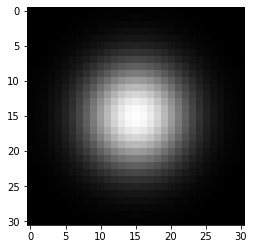

In [66]:
def gausK(sigma):
    n = 3 * sigma
    x, y = np.mgrid[-n:n+1, -n:n+1]
    H = np.exp(-(x**2 + y**2)/(2*sigma**2))
    H *= 1 / (2 * np.pi * sigma**2)
    return H
plt.imshow(gausK(5),cmap='gray')

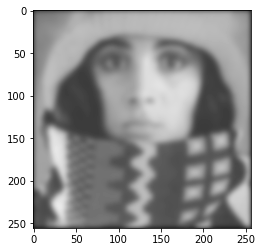

In [67]:
o = conv(C, gausK(3))
showG(o)

In [68]:
def ftconv(img,k):
    sz = (img.shape[0] - k.shape[0], img.shape[1] - k.shape[1])
    k = np.pad(k, (((sz[0]+1)//2, sz[0]//2), ((sz[1]+1)//2,sz[1]//2)))
    k = scipy.fft.ifftshift(k) # Inverse shift of kernel for some reason is needed.
    fft = scipy.fft.fft2(img)
    fft_filtered = fft * scipy.fft.fft2(k)
    f = scipy.fft.ifft2(fft_filtered)
    return np.real(f)
    

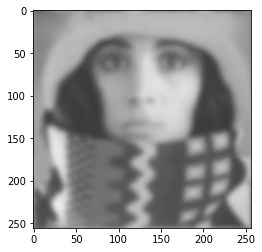

In [69]:
p = ftconv(C, gausK(3))
showG(p)

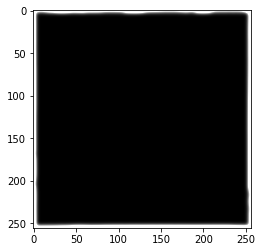

In [70]:
p = ftconv(C, gausK(3))
o = conv(C, gausK(3))
showG((p-o)*10) # Main difference between images is padding in o

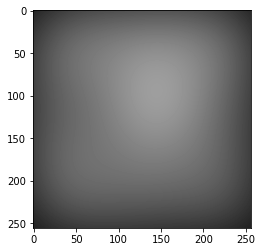

In [71]:
showG(conv(C, gausK(41)))

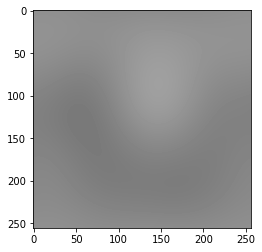

In [72]:
showG(ftconv(C, gausK(41)))

In [73]:
def runAndPlot(func, args, plot = True, times_per_arg = 1):
    res = [] # Set of results
    times = []

    for arg in args:
        t = 0
        for _ in range(times_per_arg):
            start = time.time()
            r = func(arg)
            end = time.time()
            t = t + (end - start)
        res.append(r)
        times.append(t/times_per_arg) # average time is saved

    if plot:
        plt.plot(args, times)
        plt.ylabel('Time in seconds (average over {} runs)'.format(times_per_arg))
        plt.xlabel('Kernel size')
        plt.show()
    return res, times

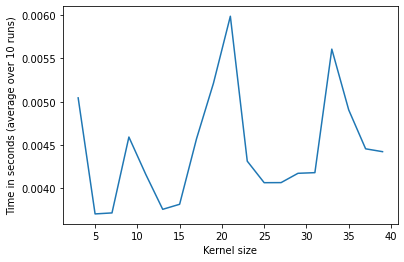

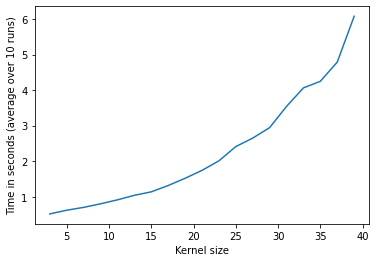

In [ ]:
_ = runAndPlot(lambda x: ftconv(C, gausK(x)), list(range(3,40,2)),times_per_arg=10)
_ = runAndPlot(lambda x: conv(C, gausK(x)), list(range(3,40,2)),times_per_arg=10)

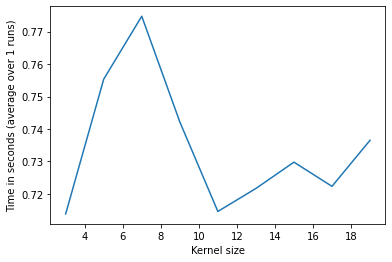

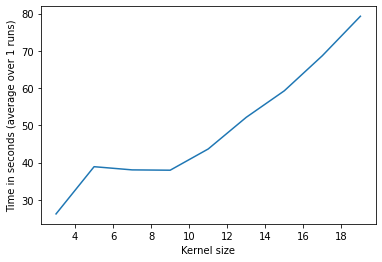

In [ ]:
_ = runAndPlot(lambda x: ftconv(A2, gausK(x)), list(range(3,21,2)),times_per_arg=1)
_ = runAndPlot(lambda x: conv(A2, gausK(x)), list(range(3,21,2)),times_per_arg=1)

In [74]:
# Part 3

def addNoise(im, a, v, w):
    cp = im.copy().astype(np.uint64)
    for x in range(im.shape[0]):
        for y in range(im.shape[1]):
            cp[x,y] = min(255, cp[x,y] + a*np.cos(v*x+w*y))
    return cp.astype(np.uint8)



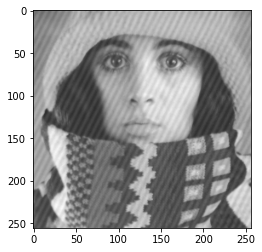

In [141]:
showG(addNoise(C, 10, .4, .8))

In [76]:
def viz(im):
    D = np.copy(im)
    fft = scipy.fft.fft2(D)
    F = np.absolute(fft)
    powerF = 8*np.log(1+F*F)
    return powerF#scipy.fft.fftshift(powerF)
    

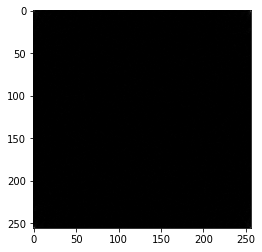

In [77]:
def reverse(im):
    return np.real(scipy.fft.ifft2(im*1/8))
showG(reverse(viz(addNoise(C, 40, .4, .8))))

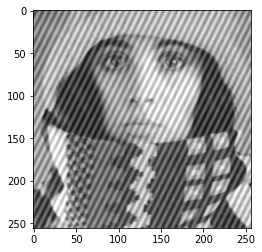

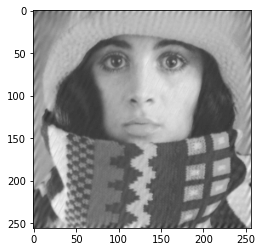

In [78]:
noise = addNoise(C, 40, .4, .8)
showG(noise)
fft = scipy.fft.fft2(noise)
fft_shift = scipy.fft.fftshift(fft)
fft_shift[105:120,90:105] = 0
fft_shift[140:160,155:175] = 0
#showG(t)
fft = scipy.fft.ifftshift(fft_shift)
plt.imshow(np.real(scipy.fft.ifft2(fft)),vmin=0,vmax=255, cmap='gray')

In [175]:
def fftviz(im):
    fft = np.copy(im)
    fft_abs = np.absolute(fft)
    powerF = 8*np.log(1+fft_abs*fft_abs)
    return scipy.fft.fftshift(powerF)

In [163]:
def removeWaveNoise(img, w, v, offset=10):
    n,m = img.shape

    fft = scipy.fft.fft2(img)

    fft_show = fftviz(fft)

    x = int((v/(2*np.pi)) * m) 
    y = int((w/(2*np.pi)) * n) 

    fft[max(y-offset, 0):min(m,y+offset),max(x-offset,0):min(x+offset,n)] = 0
    fft[max(n-y-offset,0):min(n,n-y+offset),max(0,m-x-offset):min(m,m-x+offset)] = 0

    fft_show = fftviz(fft)

    return fft_show

0.5


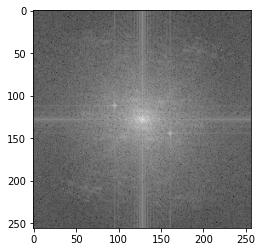

32
16


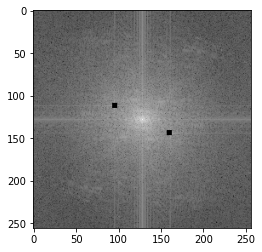

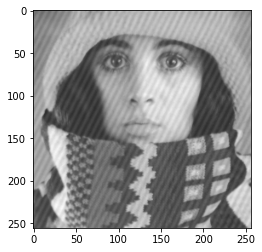

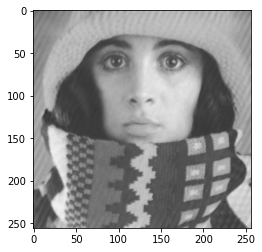

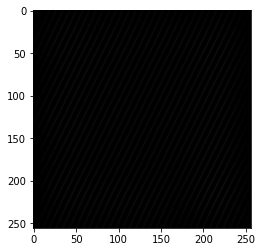

In [192]:
w = .4
v = .8
print(w/v)
noise = addNoise(C, 10, w, v)
removeWaveNoise(noise, w, v, offset=3)

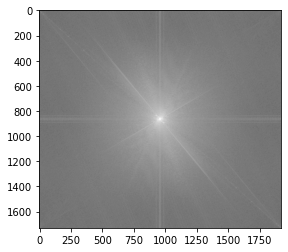

30
27


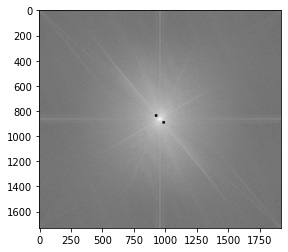

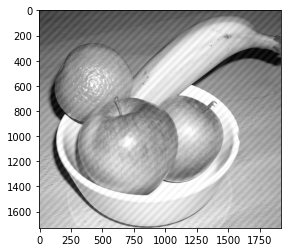

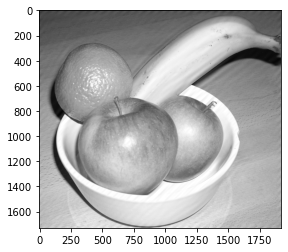

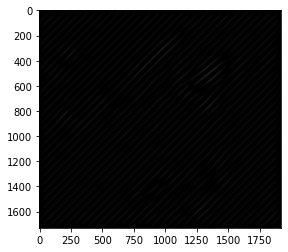

In [180]:
w = 0.1
v = 0.1
noise = addNoise(A2, 10, w, v)
removeWaveNoise(noise, w, v, offset=10)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3ad76b16-51fe-4a6e-816c-a2749aee8bd2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>